# Homework 04 — IANNwTF
## Group 27
Deadline: Nov 21, 2021 23:59

<https://forms.gle/8qwiuUXCfLjKGeg67>

## Dataset

In [1]:
import pandas as pd
# load the csv into a dataframe using the url
df_wine_quality = pd.read_csv(filepath_or_buffer="https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                             sep=";")

# have a look at the df
print(df_wine_quality.shape)
df_wine_quality.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


The column `quality` corresponds to the wine expert rating. Therefore, this column represents the target.

All other columns constitute the feature vector.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 15

# function to create a histogram of the desired df column
def createSubplotHist(data, x, ax, bins):
    '''
    data is a pandas data frame
    x is the variable to be plotted (str)
    ax is the ax object
    bins is the number of bins (int)
    '''
    sns.histplot(data=data, x=data[x], ax=ax, bins=bins)
    ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    total = float(len(data))
    addPercentages(data, x, total, ax)

# function to add percentages on top of the bars
def addPercentages(data, var, N, ax):
    '''
    data is a pandas data frame
    var is the variable to be plotted (str)
    N is the number of datapoints (float)
    ax is the ax object
    '''    
    percentages = data[var].value_counts(normalize=True).sort_index() * 100
    percentages = percentages.values
    for i, p in enumerate(ax.patches):
        percentage = percentages[i]
        x = p.get_x() + p.get_width()
        y = p.get_height()
        tex = "{}%".format(percentage.round(1))

        ax.annotate(tex, (x, y), ha='right', xytext=(0, 4),
                textcoords='offset points',)

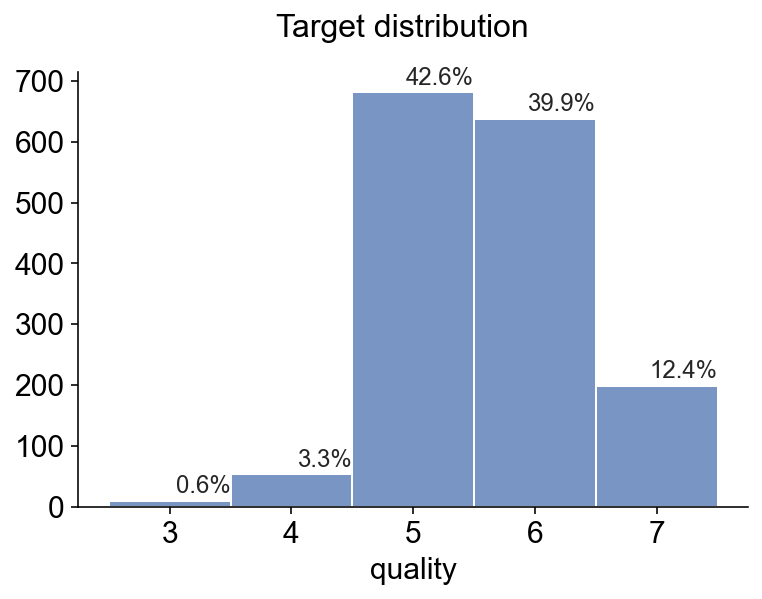

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Target distribution', fontsize=16)
sns.set(style="white")

createSubplotHist(df_wine_quality, "quality", ax, np.array(sorted(df_wine_quality["quality"].unique()))-0.5)

In [4]:
# Split the dataset into a train, test and validation datasets

df_train = df_wine_quality.sample(frac=.7) # use 70% of the dataset for the training set 
df_valid = pd.merge(df_wine_quality, df_train, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
df_test = df_valid.sample(frac=.5)
df_valid = pd.merge(df_valid, df_test, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
print(df_train.shape,df_valid.shape,df_test.shape)

(1119, 12) (178, 12) (187, 12)


In [5]:
# Separate the labels from the input and store them

labels_train = df_train.pop('quality')
labels_test = df_test.pop('quality')
labels_valid = df_valid.pop('quality')

In [6]:
# build tensorflow datasets from the features and the targets
import tensorflow as tf

ds_train = tf.data.Dataset.from_tensor_slices((df_train.values, labels_train.values))
ds_test = tf.data.Dataset.from_tensor_slices((df_test.values, labels_test.values))
ds_valid = tf.data.Dataset.from_tensor_slices((df_valid.values, labels_valid.values))

In [7]:
for features, target in ds_train.take(3):
    print('Features: {}, Target: {}'.format(features, target))

Features: [ 9.4    0.43   0.24   2.8    0.092 14.    45.     0.998  3.19   0.73
 10.   ], Target: 6
Features: [12.3     0.39    0.63    2.3     0.091   6.     18.      1.0004  3.16
  0.49    9.5   ], Target: 5
Features: [ 8.8      0.27     0.39     2.       0.1     20.      27.       0.99546
  3.15     0.69    11.2    ], Target: 6


In [8]:
# median quality of all wines
med = pd.read_csv(filepath_or_buffer="https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                             sep=";")["quality"].median()

# function to make the target binary
def make_binary(target):
    '''
    receives a target (int)
    returns a target fit for a binary classification task (threshold: median of the original data)
    '''
    temp = 1 if target > int(med) else 0
    return temp

In [9]:
# data pipeline
def prepare_data(ds):
    # create binary targets
    ds = ds.map(lambda features, target: (features, make_binary(target)))
    # shuffle, batch and prefetch the data
    ds = ds.shuffle(500).batch(32).prefetch(20)
    return ds

In [10]:
# prepare the training and the test dataset
train_dataset = ds_train.apply(prepare_data)
test_dataset = ds_test.apply(prepare_data)
valid_dataset = ds_valid.apply(prepare_data)

# Model

In [11]:
# Custom Layer
class SimpleDense(tf.keras.layers.Layer):
    '''
    Custom layer function, which inherits from the keras.layers.Layer class

    Functions:
    init: constructor
    call: calculates output
    build: creates weights and bias when model is called for the first time
    '''

    def __init__(self, units, activation):
        '''
        Constructs a fully connected layer
        
        Args:
          units (int): number of perceptrons of the layer
          activation (tf.nn activation function): activation function of the layer
        '''
        super(SimpleDense, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape): 
        '''
        Creates random weights and bias from a normal distribution

        Args:
          input_shape: dimension of the input tensor
        '''
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

    def call(self, inputs): 
        '''
        Calculates the output of the layer (forward step)

        Args:
          inputs: input tensor of the layer
        
        Returns:
          x: output of the layer
        '''

        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

In [12]:
# Custom Model
class MyModel(tf.keras.Model):
    """ 
    Custom MLP model for a binary classification task, which inherits from the keras.Model class

    Functions:
    init: constructor
    call: performs forward pass
    """
    
    def __init__(self):
        '''
        Constructs the model with 1 hidden layer (16 perceptrons) and an output layer with 1 output neuron
        '''
        super(MyModel, self).__init__()
        self.dense = SimpleDense(16, activation=tf.nn.sigmoid) 
        self.out = SimpleDense(1, activation=tf.nn.sigmoid) # output layer with 1 unit since we have a binary task

    def call(self, inputs):
        '''
        Performs a forward step in our MLP
        
        Args:
          inputs (Tensor): input to the model
        
        Returns: 
          x: output of the model
        '''
        x = self.dense(inputs)
        x = self.out(x)
        return x

# Training

In [13]:
def train_step(model, inputs, target, loss_function, optimizer):
    '''
    Forward and backward pass for one datapoint of the training set

    Args:
      model: the created tf model
      inputs: tensor of the input features
      target: target corresponding to the input features
      loss_funcion: tensorflow loss function
      optimizer: tensorflow optimizer
    
    Returns:
      loss: loss for the datapoint
    '''
    with tf.GradientTape() as tape:
        # forward step
        prediction = model(inputs, training=True)
        # calculate loss
        loss = loss_function(target, prediction)
        # calculate gradients
        gradients = tape.gradient(loss, model.trainable_variables)
    # apply optimizer
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    '''
    Tests our model by performing forward pass and calculating loss and accuracy.

    Args:
      model: the created tf model
      test_data: the prepared test dataset
      loss_funcion: tensorflow loss function
    
    Returns:
      test_loss: mean loss of this epoch
      test_accuracy: mean accuracy of this epoch
    
    '''    
    # initialize lists for accuracys and loss 
    test_accuracy_aggregator = []
    test_loss_aggregator = []
    
    for (inputs, target) in test_data:
        # forward step
        prediction = model(inputs)
        # calculate loss and accuracy and add them to the respective lists
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.round(target, 0) == np.round(prediction,0)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
    
    # calculate the mean of the loss and accuracy (for this epoch)
    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)
    
    return test_loss, test_accuracy

In [14]:
tf.keras.backend.clear_session()

# hyperparameters
num_epochs = 10
learning_rate = 0.01

# initialize the model
model = MyModel()
# initialize the loss function
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# initialize the optimizer: SGD with default parameters
optimizer = tf.keras.optimizers.SGD(learning_rate)

# initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

# testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# we train for num_epochs epochs
for epoch in range(num_epochs):
    print('Epoch: {0} starting with accuracy {1:.2f}'.format(epoch,test_accuracies[-1]))

    # training
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    # track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    # testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.84
Epoch: 1 starting with accuracy 0.84
Epoch: 2 starting with accuracy 0.83
Epoch: 3 starting with accuracy 0.83
Epoch: 4 starting with accuracy 0.83
Epoch: 5 starting with accuracy 0.83
Epoch: 6 starting with accuracy 0.83
Epoch: 7 starting with accuracy 0.84
Epoch: 8 starting with accuracy 0.84
Epoch: 9 starting with accuracy 0.83


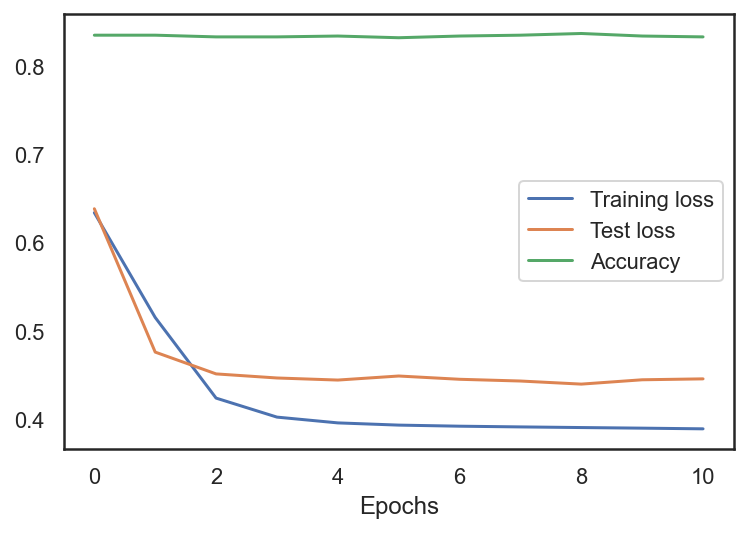

In [15]:
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Epochs")
plt.legend((line1,line2,line3),("Training loss","Test loss", "Accuracy"))
plt.show()

# Fine-tuning

In [16]:
# model with a dropout layer
class DropoutModel(tf.keras.Model):
    """ 
    Custom MLP model for a binary classification task, which inherits from the keras.Model class

    Functions:
    init: constructor
    call: performs forward pass
    """
    
    def __init__(self):
        '''
        Constructs the model with a hidden layer, a dropout layer, and an output layer with one output neuron
        '''
        super(DropoutModel, self).__init__()
        self.dense = SimpleDense(16, activation=tf.nn.sigmoid) # hidden layer
        self.dropout = tf.keras.layers.Dropout(0.5) # dropout layer
        self.out = SimpleDense(1, activation=tf.nn.sigmoid)

    def call(self, inputs, training=False):
        '''
        Performs a forward step in our MLP
        
        Args:
          inputs (Tensor): input to the model
        
        Returns: 
          x: output of the model
        '''
        x = self.dense(inputs)
        x = self.dropout(x, training=training)
        x = self.out(x)
        return x

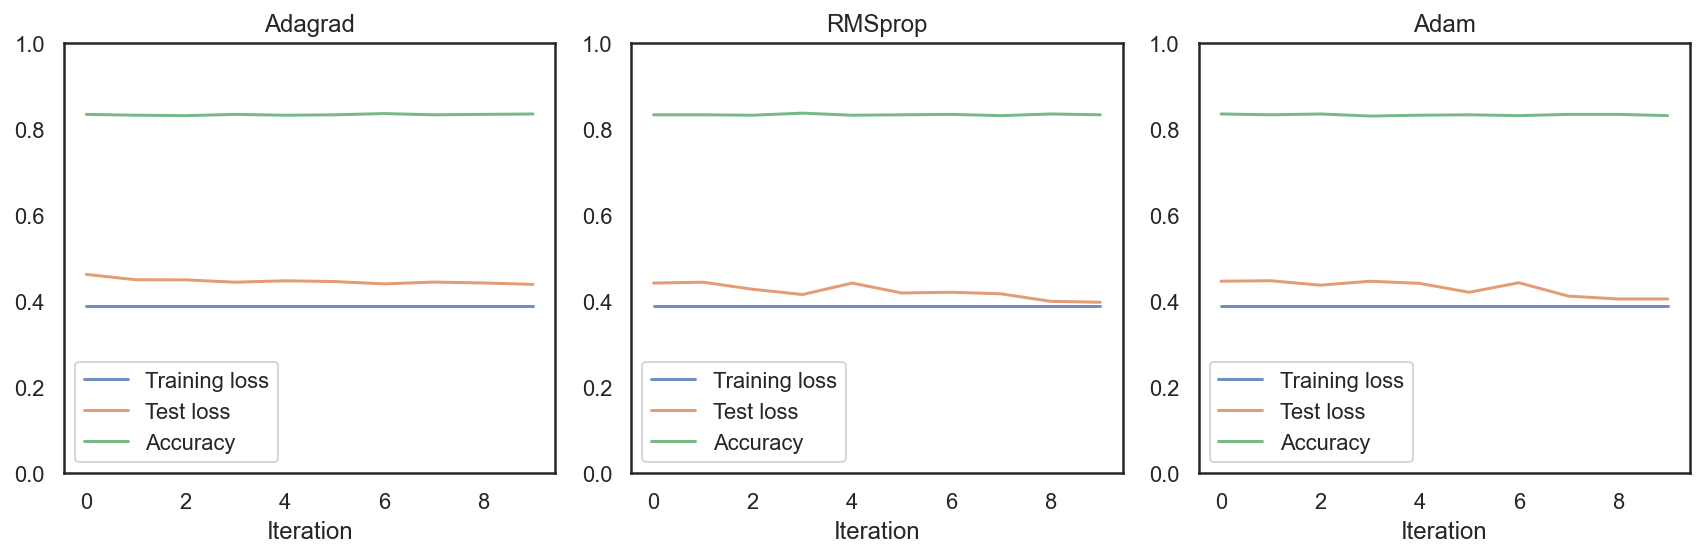

In [17]:
# compare results from different optimisers
import copy

def compare_optimizers(max_steps=10):
    
    ADA_DICT = [tf.keras.optimizers.Adagrad(learning_rate=0.01), 'Adagrad']
    RMS_DICT = [tf.keras.optimizers.RMSprop(learning_rate=0.01), 'RMSprop']
    ADAM_DICT = [tf.keras.optimizers.Adam(learning_rate=0.01), 'Adam']
    ALL_DICTS = [ADA_DICT, RMS_DICT, ADAM_DICT]
    
    dropout_model = DropoutModel()
    cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
    
    TRAIN_LOSS = {}
    TEST_LOSS = {}
    TEST_ACC = {}
    
    for opt_dict in ALL_DICTS:
        optimizer, opt_name = opt_dict
        TRAIN_LOSS[opt_name] = []
        TEST_LOSS[opt_name] = []
        TEST_ACC[opt_name] = []
        

        model = copy.deepcopy(dropout_model)

        for step in range(max_steps):
            loss_agg = []
            for input,target in train_dataset:
                train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
                loss_agg.append(train_loss)
            TRAIN_LOSS[opt_name].append(tf.reduce_mean(epoch_loss_agg))
            test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
            TEST_LOSS[opt_name].append(test_loss)
            TEST_ACC[opt_name].append(test_accuracy)
                
    fig, axs = plt.subplots(1, len(ALL_DICTS), figsize=(12, 4))
    for ax, optim_dict in zip(axs, ALL_DICTS):
        opt_name = optim_dict[1]
        ax.plot(range(max_steps), TRAIN_LOSS[opt_name], alpha=0.8, label = "Training loss")
        ax.plot(range(max_steps), TEST_LOSS[opt_name], alpha=0.8, label = "Test loss")
        ax.plot(range(max_steps), TEST_ACC[opt_name], alpha=0.8, label = "Accuracy")
        ax.set_title(opt_name)
        ax.set_xlabel('Iteration')
        ax.legend()
        ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()
compare_optimizers()